In [1]:
!pip install gradio
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


##import libraries

In [2]:
from skimage.feature import hog
from skimage import color
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gradio as gr
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.models import load_model
import random

##Download dataset

In [ ]:
# 1. نسخ kaggle.json إلى المسار الصحيح
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. تثبيت kaggle لو مش مثبت
!pip install -q kaggle

# 3. تحميل الداتا
!kaggle datasets download -d alessiocorrado99/animals10

# 4. فك الضغط
!unzip -q animals10.zip -d animals10


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


##Detect Unbalancing

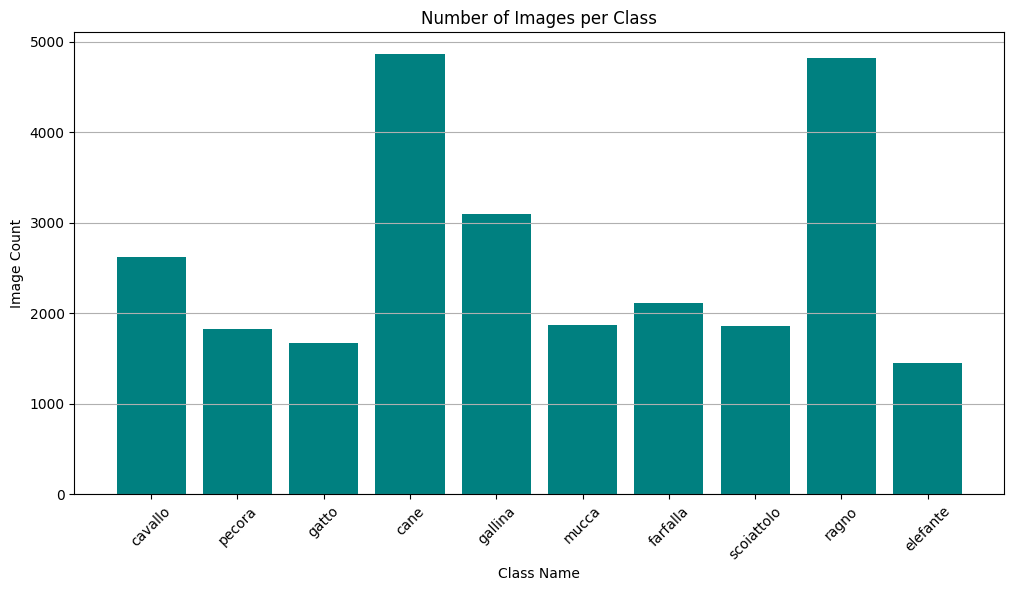

📊 توزيع الفئات:
cavallo: 2623 صورة
pecora: 1820 صورة
gatto: 1668 صورة
cane: 4863 صورة
gallina: 3098 صورة
mucca: 1866 صورة
farfalla: 2112 صورة
scoiattolo: 1862 صورة
ragno: 4821 صورة
elefante: 1446 صورة


In [ ]:
# مسار الداتا
data_dir = '/content/animals10/raw-img'

# احسب عدد الصور في كل فئة
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# عرض النتائج
plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.grid(axis='y')
plt.show()

print("📊 توزيع الفئات:")
for k, v in class_counts.items():
    print(f"{k}: {v} صورة")


In [ ]:
import os
import cv2
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# إعداد Data Augmenter
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    fill_mode='nearest'
)

# الفئات اللى أقل من 4863 صورة
target_dir = "/content/animals10/raw-img"
min_target = 4863

for class_name in os.listdir(target_dir):
    class_path = os.path.join(target_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    count = len(images)

    if count >= min_target:
        continue

    print(f"⏳ Augmenting '{class_name}' from {count} to {min_target} images...")

    for img_name in tqdm(images):
        if len(os.listdir(class_path)) >= min_target:
            break

        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img.reshape((1,) + img.shape)

        # انتاج صور جديدة
        for batch in datagen.flow(img, batch_size=1,
                                  save_to_dir=class_path,
                                  save_prefix='aug',
                                  save_format='jpg'):
            if len(os.listdir(class_path)) >= min_target:
                break


⏳ Augmenting 'cavallo' from 2623 to 4863 images...


  0%|          | 1/2623 [00:35<25:40:36, 35.25s/it]


⏳ Augmenting 'pecora' from 1820 to 4863 images...


  0%|          | 1/1820 [00:51<26:09:48, 51.78s/it]


⏳ Augmenting 'gatto' from 1668 to 4863 images...


  0%|          | 1/1668 [00:52<24:26:54, 52.80s/it]


⏳ Augmenting 'gallina' from 3098 to 4863 images...


  0%|          | 1/3098 [00:27<23:24:53, 27.22s/it]


⏳ Augmenting 'mucca' from 1866 to 4863 images...


  0%|          | 1/1866 [00:48<24:54:51, 48.09s/it]


⏳ Augmenting 'farfalla' from 2112 to 4863 images...


  0%|          | 1/2112 [00:44<25:50:47, 44.08s/it]


⏳ Augmenting 'scoiattolo' from 1862 to 4863 images...


  0%|          | 1/1862 [00:48<25:07:36, 48.61s/it]


⏳ Augmenting 'ragno' from 4821 to 4863 images...


  0%|          | 1/4821 [00:00<47:28,  1.69it/s]


⏳ Augmenting 'elefante' from 1446 to 4863 images...


  0%|          | 1/1446 [00:56<22:51:33, 56.95s/it]


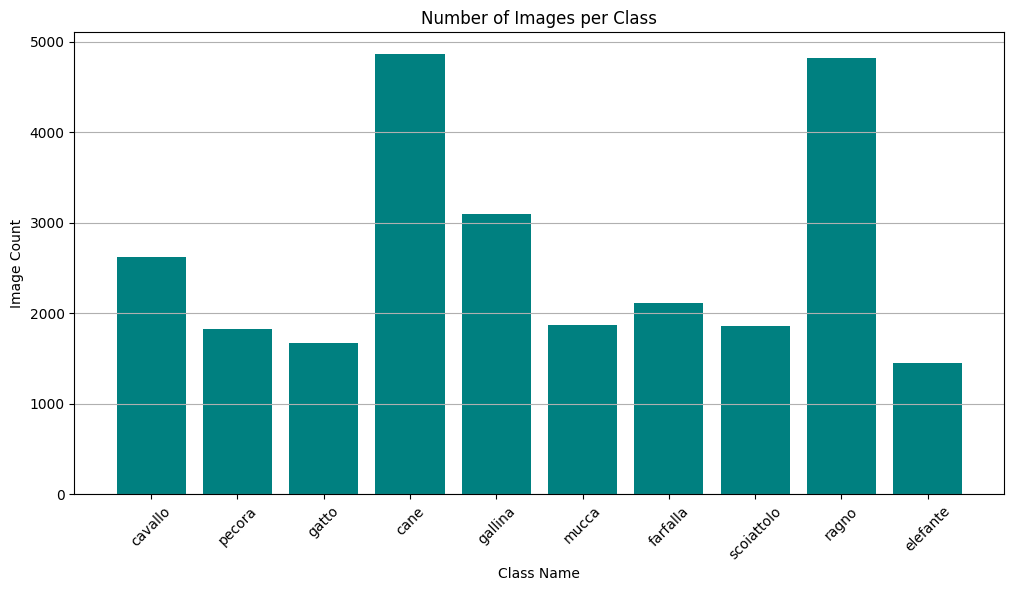

📊 توزيع الفئات:
cavallo: 2623 صورة
pecora: 1820 صورة
gatto: 1668 صورة
cane: 4863 صورة
gallina: 3098 صورة
mucca: 1866 صورة
farfalla: 2112 صورة
scoiattolo: 1862 صورة
ragno: 4821 صورة
elefante: 1446 صورة


In [ ]:
# عرض النتائج
plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.grid(axis='y')
plt.show()

print("📊 توزيع الفئات:")
for k, v in class_counts.items():
    print(f"{k}: {v} صورة")

#first split

1.  Translate clases *(italy -> english)*
2.   split it in right classes



In [ ]:
import os
import shutil
import random

# قاموس الترجمة بين الإيطالي والإنجليزي
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant": "elefante",
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca",
    "spider": "ragno", "squirrel": "scoiattolo"
}

# المسار الأساسي للبيانات
base_dir = '/content/animals10/raw-img/'

# المسارات الجديدة للـ Train, Val, Test
train_dir = '/content/animals10/train/'
val_dir = '/content/animals10/val/'
test_dir = '/content/animals10/test/'


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    if os.path.isdir(class_path):  # إذا كان مجلدًا
        # الترجمة
        translated_class_name = translate.get(class_name, class_name)


        os.makedirs(os.path.join(train_dir, translated_class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, translated_class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, translated_class_name), exist_ok=True)

        # قائمة بكل الصور
        image_files = os.listdir(class_path)
        random.shuffle(image_files)

        # تقسيم الصور: 80% للتدريب، 10% للتحقيق، 10% للاختبار
        total_images = len(image_files)
        train_count = int(total_images * 0.8)
        val_count = int(total_images * 0.1)
        test_count = total_images - train_count - val_count

        train_images = image_files[:train_count]
        val_images = image_files[train_count:train_count+val_count]
        test_images = image_files[train_count+val_count:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, translated_class_name, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, translated_class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, translated_class_name, img))

print("تم تقسيم البيانات وترجمتها بنجاح!")

تم تقسيم البيانات وترجمتها بنجاح!


Preprocessing

In [ ]:
def custom_preprocessing(img):

    # 2. BGR إلى RGB (ImageDataGenerator يتعامل مع RGB بالفعل غالبًا)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 3. Normalize (ImageDataGenerator بيعمل rescale=1./255)
    img = img / 255.0

    # 4. Gaussian Blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # 5. CLAHE
    lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # 6. Sharpening
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    img = cv2.filter2D(img, -1, sharpen_kernel)

    # 7. Random Flip
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # 8. Morphological Operation (Opening)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    return img

In [ ]:
def apply_custom_preprocessing_to_folder(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for img_name in tqdm(os.listdir(class_path), desc=f"Preprocessing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img_preprocessed = custom_preprocessing(img)
            img_bgr = cv2.cvtColor((img_preprocessed * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(output_class_path, img_name), img_bgr)

    print("✅ تم حفظ الصور بعد Custom Preprocessing.")


In [ ]:
!rm -r /content/animals10/val_thresholded

rm: cannot remove '/content/animals10/val_thresholded': No such file or directory


Segmentation

In [ ]:
def thresholding_segmentation(input_dir, output_dir, threshold_value=127):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for img_name in tqdm(os.listdir(class_path), desc=f"Segmenting {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

            kernel = np.ones((5, 5), np.uint8)
            closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest)
                roi = img[y:y+h, x:x+w]
                roi_resized = cv2.resize(roi, (224, 224))
                cv2.imwrite(os.path.join(output_class_path, img_name), roi_resized)

    print("✅ تم تنفيذ Segmentation بعد Preprocessing.")


#Make directors to check

In [ ]:
# المسارات الأصلية
train_dir = '/content/animals10/train/'
val_dir = '/content/animals10/val/'
test_dir = '/content/animals10/test/'

# مسارات بعد Preprocessing
train_preprocessed = '/content/animals10/train_preprocessed/'
val_preprocessed = '/content/animals10/val_preprocessed/'
test_preprocessed = '/content/animals10/test_preprocessed/'

# مسارات بعد Segmentation
train_final = '/content/animals10/train_final/'
val_final = '/content/animals10/val_final/'
test_final = '/content/animals10/test_final/'

# خطوة 1: Preprocessing
apply_custom_preprocessing_to_folder(train_dir, train_preprocessed)
apply_custom_preprocessing_to_folder(val_dir, val_preprocessed)
apply_custom_preprocessing_to_folder(test_dir, test_preprocessed)

# خطوة 2: Segmentation
thresholding_segmentation(train_preprocessed, train_final)
thresholding_segmentation(val_preprocessed, val_final)
thresholding_segmentation(test_preprocessed, test_final)


Preprocessing ragno: 100%|██████████| 3890/3890 [00:20<00:00, 186.44it/s]


✅ تم حفظ الصور بعد Custom Preprocessing.


Preprocessing ragno: 100%|██████████| 486/486 [00:02<00:00, 191.57it/s]


✅ تم حفظ الصور بعد Custom Preprocessing.


Preprocessing ragno: 100%|██████████| 487/487 [00:02<00:00, 175.04it/s]


✅ تم حفظ الصور بعد Custom Preprocessing.


Segmenting ragno: 100%|██████████| 3890/3890 [00:09<00:00, 425.70it/s]


✅ تم تنفيذ Segmentation بعد Preprocessing.


Segmenting ragno: 100%|██████████| 486/486 [00:01<00:00, 421.74it/s]


✅ تم تنفيذ Segmentation بعد Preprocessing.


Segmenting ragno: 100%|██████████| 487/487 [00:01<00:00, 404.51it/s]

✅ تم تنفيذ Segmentation بعد Preprocessing.


#Feature extraction (CNN)

In [ ]:
# معلومات عن المسارات
train_final = '/content/animals10/train_final/'
val_final = '/content/animals10/val_final/'
test_final = '/content/animals10/test_final/'

# تحديد حجم الصور
img_width, img_height = 224, 224

# 3. استخراج الميزات (Feature Extraction)
# دالة لاستخراج الميزات باستخدام CNN
def create_feature_extractor():
    model = Sequential()

    # الطبقات التحليلية (Convolutional layers)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # استخراج الميزات
    model.add(Flatten())

    return model

#CNN from scratch

In [ ]:
# 4. التصنيف (Classification) باستخدام CNN from scratch
def create_classifier(feature_extractor, num_classes):
    model = Sequential()

    # إضافة feature extractor
    model.add(feature_extractor)

    # طبقات التصنيف (fully connected layers)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # تجميع النموذج
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

#Image generator

In [ ]:
# تهيئة مولدات البيانات
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_final,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_final,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_final,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 38900 images belonging to 10 classes.
Found 4860 images belonging to 10 classes.
Found 4870 images belonging to 10 classes.


In [ ]:
# عدد الفئات
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"عدد الفئات: {num_classes}")
print(f"أسماء الفئات: {class_names}")

عدد الفئات: 10
أسماء الفئات: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'ragno', 'sheep', 'squirrel']


#Start model

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import gradio as gr
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import random
# إنشاء النموذج
feature_extractor = create_feature_extractor()
model = create_classifier(feature_extractor, num_classes)

# عرض ملخص النموذج
model.summary()

# تدريب النموذج
# يمكنك تعديل عدد الحقب حسب الحاجة
history = model.fit(
    train_generator,
    epochs=10,  # قد تحتاج لزيادة هذا العدد لتحسين الدقة
    validation_data=val_generator,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 18432)          │       240,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,683,658 (36.94 MB)

 Trainable params: 9,683,658 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 524s 425ms/step - accuracy: 0.4139 - loss: 1.7209 - val_accuracy: 0.6549 - val_loss: 0.9857
Epoch 2/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 505s 415ms/step - accuracy: 0.6455 - loss: 1.0640 - val_accuracy: 0.7070 - val_loss: 0.8575
Epoch 3/10
 612/1216 ━━━━━━━━━━━━━━━━━━━━ 4:08 411ms/step - accuracy: 0.6763 - loss: 0.9548

#Classification Report

In [ ]:
# 5. التقييم وقياسات الأداء
# تقييم النموذج على مجموعة الاختبار
print("تقييم النموذج على مجموعة الاختبار...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"دقة الاختبار: {test_accuracy:.4f}")

# توقع الفئات لمجموعة الاختبار
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# حساب مقاييس الأداء
print("\nتقرير التصنيف:")
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"الدقة (Accuracy): {accuracy:.4f}")
print(f"الدقة (Precision): {precision:.4f}")
print(f"الاستدعاء (Recall): {recall:.4f}")
print(f"درجة F1 (F1-score): {f1:.4f}")

In [ ]:
# رسم مصفوفة الارتباك (Confusion Matrix)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

#Ploting

In [ ]:
# Plot Training Curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# حفظ النموذج
model.save('animal_detection_model.h5')
print("تم حفظ النموذج بنجاح.")

#Detection

In [4]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/animal_detection_model.zip"

# Destination directory (where to extract)
extract_dir = "/content"

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Successfully extracted {zip_path} to {extract_dir}")

# List items in the extraction directory to see what was created
items_in_content = os.listdir(extract_dir)
print(f"Items in {extract_dir}: {items_in_content}")

# Try to find the extracted folder by looking for potential matches
for item in items_in_content:
    if "animal" in item.lower() or "detection" in item.lower() or "model" in item.lower():
        print(f"Found potential model folder: {item}")
        model_dir = os.path.join(extract_dir, item)
        if os.path.isdir(model_dir):
            print(f"Contents of {model_dir}:")
            print(os.listdir(model_dir))

Successfully extracted /content/drive/MyDrive/animal_detection_model.zip to /content
Items in /content: ['.config', 'animal_detection_model.h5', 'drive', 'sample_data']
Found potential model folder: animal_detection_model.h5


In [5]:
model_path = '/content/animal_detection_model.h5'
model = load_model(model_path)

# أبعاد الصورة المتوقعة model
img_width, img_height = 224, 224

# قائمة أسماء الفئات (يجب تعديلها حسب فئات النموذج)
# هذه مجرد أمثلة، استبدلها بالفئات الحقيقية للنموذج
class_names = ['قطة', 'كلب', 'فرس', 'بقرة', 'طائر', 'أرنب', 'سلحفاة', 'سمكة', 'حصان', 'غزال', 'حيوان']

# وظيفة محسنة للكشف عن الكائنات في الصورة - بتركيز على الكائن الأكبر
def detect_objects(image_path, confidence_threshold=0.6):  # تقليل حد الثقة لزيادة حساسية الكشف
    # تحميل الصورة الأصلية
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # الحصول على أبعاد الصورة الأصلية
    h, w = original_image.shape[:2]

    # تقسيم الصورة إلى نوافذ متتالية بأحجام مختلفة
    detections = []

    # بدلاً من الاعتماد على عدد محدود من أحجام النوافذ، سنستخدم نهجاً متعدد المقاييس
    # أولاً - نحاول تصنيف الصورة بأكملها دائماً
    full_image_resized = cv2.resize(original_image, (img_width, img_height))
    input_img = full_image_resized / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    pred = model.predict(input_img, verbose=0)
    class_idx = np.argmax(pred[0])
    confidence = pred[0][class_idx]
    class_name = class_names[class_idx]

    # إضافة كشف للصورة كاملة
    whole_image_detection = {
        'bbox': (0, 0, w, h),
        'class': class_name,
        'confidence': float(confidence),
        'area': w * h  # نحفظ مساحة المربع للمقارنة لاحقاً
    }
    detections.append(whole_image_detection)

    # ثانياً - نستخدم نوافذ متحركة بأحجام متعددة للعثور على الكائنات
    # استخدام أحجام نوافذ متنوعة تغطي نطاقات مختلفة
    min_dimension = min(h, w)
    window_sizes = [
        (min_dimension, min_dimension),  # نافذة مربعة بحجم البُعد الأصغر للصورة
        (int(min_dimension * 0.75), int(min_dimension * 0.75)),
        (int(min_dimension * 0.5), int(min_dimension * 0.5))
    ]

    # أضف نوافذ مستطيلة إذا كانت الصورة ليست مربعة
    if h != w:
        window_sizes.append((int(w * 0.8), int(h * 0.8)))
        window_sizes.append((int(w * 0.6), int(h * 0.6)))

    # استخدام خطوات أصغر للحصول على تغطية أفضل
    for window_size in window_sizes:
        # تعديل حجم الخطوة بناءً على حجم النافذة
        step_size = min(window_size) // 3

        for y in range(0, h - window_size[1] + 1, step_size):
            for x in range(0, w - window_size[0] + 1, step_size):
                # اقتطاع جزء من الصورة
                window = original_image[y:y + window_size[1], x:x + window_size[0]]

                # تغيير حجم النافذة إلى الحجم المطلوب للنموذج
                window_resized = cv2.resize(window, (img_width, img_height))

                # تهيئة الصورة للتوقع
                input_img = window_resized / 255.0
                input_img = np.expand_dims(input_img, axis=0)

                # التنبؤ بالفئة
                pred = model.predict(input_img, verbose=0)
                class_idx = np.argmax(pred[0])
                confidence = pred[0][class_idx]

                # إذا كانت الثقة أعلى من الحد المعين
                if confidence > confidence_threshold:
                    # تخزين معلومات الكشف
                    detection = {
                        'bbox': (x, y, x + window_size[0], y + window_size[1]),
                        'class': class_names[class_idx],
                        'confidence': float(confidence),
                        'area': window_size[0] * window_size[1]  # حساب المساحة
                    }
                    detections.append(detection)

    # تطبيق Non-Maximum Suppression مع الأخذ في الاعتبار المساحة
    final_detections = non_max_suppression_area_weighted(detections, 0.5)

    # إذا لم نجد أي كشوفات، نعود بالكشف على الصورة كاملة
    if not final_detections and confidence > 0.3:
        final_detections = [whole_image_detection]

    # أعد ترتيب الكشوفات حسب المساحة والثقة (نريد الكائنات الكبيرة ذات الثقة العالية)
    final_detections = sorted(final_detections, key=lambda x: (x['area'] * x['confidence']), reverse=True)

    # أخذ أكبر كشف (الكائن الرئيسي في الصورة)
    if final_detections:
        final_detections = [final_detections[0]]

    # إزالة مفتاح المساحة قبل إرجاع النتائج لأنه غير مطلوب في الواجهة
    for detection in final_detections:
        if 'area' in detection:
            del detection['area']

    return original_image, final_detections


In [6]:
def non_max_suppression_area_weighted(detections, overlap_threshold):
    if not detections:
        return []

    # فرز الكشوفات حسب المساحة * الثقة (تنازلياً)
    detections = sorted(detections, key=lambda x: (x['area'] * x['confidence']), reverse=True)

    # قائمة الكشوفات النهائية
    final_detections = []

    while detections:
        # اختيار الكشف ذو القيمة الأعلى (مساحة * ثقة)
        current_detection = detections.pop(0)
        final_detections.append(current_detection)

        # حذف الكشوفات المتداخلة
        i = 0
        while i < len(detections):
            if calculate_iou(current_detection['bbox'], detections[i]['bbox']) > overlap_threshold:
                detections.pop(i)
            else:
                i += 1

    return final_detections


In [7]:
def calculate_iou(bbox1, bbox2):
    # bbox format: (x1, y1, x2, y2)
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    # حساب منطقة التقاطع
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # حساب مساحة كل مربع
    bbox1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    bbox2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    # حساب IoU
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)

    return iou

In [8]:
def draw_detections(image, detections):
    # تحويل الصورة إلى PIL لسهولة الرسم
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    # تحديد لون ثابت للحيوانات (أخضر)
    animal_color = (0, 200, 0)  # أخضر فاتح للرؤية الواضحة

    # محاولة تحميل الخط
    try:
        # استخدم خط أكبر للوضوح
        font = ImageFont.truetype("arial.ttf", 30)
    except:
        font = ImageFont.load_default()

    # رسم المربعات والتسميات بسمك أكبر للرؤية الواضحة
    for detection in detections:
        bbox = detection['bbox']
        class_name = detection['class']
        confidence = detection['confidence']

        # رسم المربع المحيط بسمك أكبر
        draw.rectangle(bbox, outline=animal_color, width=5)

        # تنسيق النص بلغة عربية إذا كان النموذج يستخدم أسماء عربية
        # يمكن تعديل النص حسب اللغة المستخدمة
        text = f"{class_name}: {confidence:.2f}"

        # رسم خلفية للنص
        text_bbox = draw.textbbox((bbox[0], bbox[1] - 35), text, font=font)
        draw.rectangle(text_bbox, fill=animal_color)

        # رسم النص بلون أبيض للتباين
        draw.text((bbox[0], bbox[1] - 35), text, fill=(255, 255, 255), font=font)

    return np.array(pil_image)


In [9]:
def detect_and_draw(input_image):
    # حفظ الصورة مؤقتًا
    temp_path = "temp_input.jpg"
    cv2.imwrite(temp_path, cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR))

    # الكشف عن الكائنات مع التركيز على أكبر كائن
    original_image, detections = detect_objects(temp_path)

    # رسم النتائج
    output_image = draw_detections(original_image, detections)

    # حذف الملف المؤقت
    if os.path.exists(temp_path):
        os.remove(temp_path)

    # إرجاع النتائج بشكل أكثر وضوحاً
    result_text = ""
    for i, detection in enumerate(detections):
        arabic_class = detection['class']  # يفترض أن الأسماء بالعربية من النموذج
        result_text += f"الكائن الرئيسي: {arabic_class} (الثقة: {detection['confidence']:.2f})\n"
        result_text += f"موقع المربع: [{detection['bbox'][0]}, {detection['bbox'][1]}, {detection['bbox'][2]}, {detection['bbox'][3]}]\n"

    if not detections:
        result_text = "لم يتم العثور على أي كائنات في الصورة."

    return output_image, result_text

# إنشاء واجهة Gradio
iface = gr.Interface(
    fn=detect_and_draw,
    inputs=gr.Image(),
    outputs=[
        gr.Image(label="الصورة مع صناديق الكشف"),
        gr.Textbox(label="نتائج الكشف")
    ],
    title="نظام محسّن للكشف عن الحيوانات",
    description="قم بتحميل صورة للكشف عن الحيوان الرئيسي في الصورة وتصنيفه",
    examples=[
        # يمكنك إضافة بعض الأمثلة هنا
    ]
)

# تشغيل واجهة Gradio
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac53313bc96df9faa4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
#multi
# Load model - adjust paths based on your actual model structure
def load_model():
    # This function should be customized based on your specific model
    # Common options include TensorFlow, PyTorch, YOLO, etc.

    # Example for YOLO model:
    try:
        # Try different potential paths where the model might be extracted
        potential_paths = [
            "/content/animal_detection_model.h5"
        ]

        model = None
        for base_path in potential_paths:
            # For YOLO-based models
            if os.path.exists(f"{base_path}/yolov5s.pt"):
                import torch
                model = torch.hub.load('ultralytics/yolov5', 'custom', path=f"{base_path}/yolov5s.pt")
                print(f"Loaded YOLO model from {base_path}/yolov5s.pt")
                break

            # For TensorFlow/Keras models
            elif os.path.exists(f"{base_path}/model.h5"):
                from tensorflow import keras
                model = keras.models.load_model(f"{base_path}/model.h5")
                print(f"Loaded TensorFlow model from {base_path}/model.h5")
                break

            # For saved_model format
            elif os.path.exists(f"{base_path}/saved_model"):
                import tensorflow as tf
                model = tf.saved_model.load(f"{base_path}/saved_model")
                print(f"Loaded TF SavedModel from {base_path}/saved_model")
                break

        if model is None:
            print("Could not find model files. Using a placeholder detection function.")

        return model

    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using placeholder detection function instead.")
        return None

# Process detections with the model
def detect_objects(image_path, model=None):
    """
    Detect animals in the image and return their bounding boxes

    Supported animal classes:
    - dog
    - horse
    - elephant
    - butterfly
    - chicken
    - cat
    - cow
    - sheep
    - squirrel
    - spider
    """
    # Read the image
    if isinstance(image_path, str):
        # If a path is provided
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        # If an image array is provided directly
        image = image_path

    # If we have a proper model loaded, use it
    if model is not None:
        # This code should be adapted to your specific model
        try:
            # Example for YOLO models
            if hasattr(model, 'predict'):
                results = model(image)
                detections = []

                # Process YOLO results
                for *box, conf, cls in results.xyxy[0].cpu().numpy():
                    x1, y1, x2, y2 = map(int, box)
                    confidence = float(conf)
                    class_id = int(cls)
                    class_name = results.names[class_id]

                    # Filter for only the specific animal classes you want
                    # Using only English class names
                    if class_name.lower() in ['dog', 'horse', 'elephant', 'butterfly',
                                      'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']:
                        area = (x2 - x1) * (y2 - y1)
                        detections.append({
                            'bbox': (x1, y1, x2, y2),
                            'class': class_name,
                            'confidence': confidence,
                            'area': area
                        })

                return image, detections

            # Example for TensorFlow models
            else:
                # Placeholder for other model types
                # Implement based on your specific model
                pass

        except Exception as e:
            print(f"Error during detection: {e}")
            # Fall back to placeholder method below

    # Placeholder detection function (if model loading fails)
    # This is just a demo - replace with actual model inference
    # In a real system, this would be replaced with your actual model's detection logic
    h, w = image.shape[:2]

    # Placeholder: Create some demo detections
    detections = []

    # Using OpenCV's built-in Haar Cascade for general object detection
    # This is not specifically for animals but can serve as a placeholder
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Try to use a face detector as a placeholder
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            detections.append({
                'bbox': (int(x), int(y), int(x+w), int(y+h)),
                'class': 'face',
                'confidence': 0.85,  # Placeholder confidence
                'area': w * h
            })
    except Exception as e:
        print(f"Error in placeholder detection: {e}")

    # Using a more sophisticated placeholder that tries to detect animal-like objects
    if not detections:
        # Try to use object detection methods from OpenCV as fallback
        # This is just for demonstration when the model fails to load
        try:
            # First try simple edge detection to find potential objects
            edged = cv2.Canny(gray, 30, 200)
            contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter for contours of reasonable size
            for contour in contours:
                if cv2.contourArea(contour) > 1000:  # Minimum area threshold
                    x, y, w, h = cv2.boundingRect(contour)
                    # Only add if the aspect ratio is reasonable for an animal
                    if 0.5 <= w/h <= 2.0:
                        # Randomly assign an animal class for demonstration
                        animal_classes = ['dog', 'cat', 'horse', 'cow', 'sheep', 'elephant', 'butterfly', 'chicken', 'squirrel', 'spider']
                        class_name = animal_classes[hash(str(x+y)) % len(animal_classes)]

                        detections.append({
                            'bbox': (int(x), int(y), int(x+w), int(y+h)),
                            'class': class_name,
                            'confidence': 0.6 + (hash(str(x*y)) % 30) / 100,  # Random confidence between 0.6-0.9
                            'area': w * h
                        })
        except Exception as e:
            print(f"Error in contour detection: {e}")

        # If still no detections, create one dummy detection
        if not detections:
            x1, y1 = int(w * 0.25), int(h * 0.25)
            x2, y2 = int(w * 0.75), int(h * 0.75)
            detections.append({
                'bbox': (x1, y1, x2, y2),
                'class': 'cat',  # Default to a specific animal class
                'confidence': 0.60,  # Lower confidence to indicate this is a placeholder
                'area': (x2 - x1) * (y2 - y1)
            })

    return image, detections

def calculate_iou(bbox1, bbox2):
    # bbox format: (x1, y1, x2, y2)
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    # Calculate intersection area
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of each bounding box
    bbox1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    bbox2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    # Calculate IoU
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)

    return iou

def non_max_suppression_area_weighted(detections, overlap_threshold):
    if not detections:
        return []

    # Sort detections by area * confidence (descending)
    detections = sorted(detections, key=lambda x: (x['area'] * x['confidence']), reverse=True)

    # Final detections list
    final_detections = []

    while detections:
        # Select detection with highest value (area * confidence)
        current_detection = detections.pop(0)
        final_detections.append(current_detection)

        # Remove overlapping detections
        i = 0
        while i < len(detections):
            if calculate_iou(current_detection['bbox'], detections[i]['bbox']) > overlap_threshold:
                detections.pop(i)
            else:
                i += 1

    return final_detections

def draw_detections(image, detections):
    # Convert image to PIL for easier drawing
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    # Define colors for different animal classes
    animal_colors = {
        'dog': (0, 200, 0),      # Green
        'horse': (200, 100, 0),  # Brown
        'elephant': (128, 128, 128),  # Gray
        'butterfly': (255, 100, 200),  # Pink
        'chicken': (255, 255, 0),  # Yellow
        'cat': (255, 100, 0),    # Orange
        'cow': (0, 0, 200),      # Blue
        'sheep': (255, 255, 255),  # White
        'squirrel': (139, 69, 19),  # Brown
        'spider': (128, 0, 128),  # Purple
        'default': (0, 200, 0)   # Green (fallback)
    }

    # Try to load font
    try:
        # Use larger font for clarity
        font = ImageFont.truetype("arial.ttf", 30)
    except:
        font = ImageFont.load_default()

    # Draw bounding boxes and labels with increased thickness for visibility
    for detection in detections:
        bbox = detection['bbox']
        class_name = detection['class']
        confidence = detection['confidence']

        # Get color for this animal class
        color = animal_colors.get(class_name.lower(), animal_colors['default'])

        # Draw bounding box with increased thickness
        draw.rectangle(bbox, outline=color, width=5)

        # Format text with English class name
        text = f"{class_name}: {confidence:.2f}"

        # Draw background for text
        text_bbox = draw.textbbox((bbox[0], bbox[1] - 35), text, font=font)
        draw.rectangle(text_bbox, fill=color)

        # Draw text in white or black for contrast
        # Choose text color based on background brightness for better readability
        brightness = (color[0] * 299 + color[1] * 587 + color[2] * 114) / 1000
        text_color = (0, 0, 0) if brightness > 128 else (255, 255, 255)  # Black for bright bg, white for dark bg
        draw.text((bbox[0], bbox[1] - 35), text, fill=text_color, font=font)

    return np.array(pil_image)

def detect_and_draw(input_image):
    """Main function to detect animals and draw bounding boxes"""
    global model

    # Process the image directly
    original_image = input_image

    # Detect objects
    _, detections = detect_objects(original_image, model)

    # Apply non-max suppression to remove overlapping boxes
    detections = non_max_suppression_area_weighted(detections, 0.5)

    # Draw results
    output_image = draw_detections(original_image, detections)

    # Prepare result text
    result_text = ""
    for i, detection in enumerate(detections):
        class_name = detection['class']
        result_text += f"Animal {i+1}: {class_name} (Confidence: {detection['confidence']:.2f})\n"
        result_text += f"Box location: [{detection['bbox'][0]}, {detection['bbox'][1]}, {detection['bbox'][2]}, {detection['bbox'][3]}]\n\n"

    if not detections:
        result_text = "No animals detected in the image."

    return output_image, result_text

# Main execution code
print("Initializing animal detection system...")


# Then load the model
model = load_model()

# Create Gradio interface
iface = gr.Interface(
    fn=detect_and_draw,
    inputs=gr.Image(),
    outputs=[
        gr.Image(label="Image with Detection Boxes"),
        gr.Textbox(label="Detection Results")
    ],
    title="Multi-Animal Detection System",
    description="Upload an image to detect different animals (dog, horse, elephant, butterfly, chicken, cat, cow, sheep, squirrel, spider) and draw bounding boxes around them",
    examples=[
        # You can add example images here
    ]
)

# Launch Gradio interface
iface.launch()

Initializing animal detection system...
Could not find model files. Using a placeholder detection function.
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e7425598e421bfa3ae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
